In [14]:
# !pip install pandasql

In [2]:
import numpy as np
import pandas as pd
from math import log
import pandasql as ps
import math
from statistics import mean
import sys
sys.path.append("/Users/fennyzalavadia/Desktop/Verusen_2/tombstone")
from base.services.data_preprocessing.nlp_pre_processing import NLPPreProcessing
nlp = NLPPreProcessing()

In [3]:
import json
def parse_json(s):
    try:
        return json.loads(s)
    except json.JSONDecodeError:
        return None

In [4]:
df = pd.read_csv('Dataset/Verusen Manufacturer Pair Annotation Task - Task 2.csv')

In [5]:
df.columns

Index(['Unnamed: 0', 'Company A', 'Company B', 'Label', 'Confidence', 'Source',
       'Notes', 'Unnamed: 7', 'Code', 'Unnamed: 9'],
      dtype='object')

In [6]:
# Load The dataset containing information
data = pd.read_csv('Dataset/manufacturer_name_materialdetail_export.csv',index_col=None)
#df = pd.read_csv('Dataset/Verusen Manufacturer Pair Annotation Task - Task-gdrive.csv')
#dropping rightmost 2 columns and last row
df.drop(['Unnamed: 0', 'Unnamed: 7', 'Code', 'Unnamed: 9','Source','Notes'], axis=1,inplace = True)

In [7]:
df.rename(columns={'Company A': 'Company_A','Company B': 'Company_B'},inplace = True)

In [8]:
df_new = df[(df['Label'] == 1) &(df['Confidence'] == 10)]
df = df_new.append(df[(df['Label'] == 0)&(df['Confidence'] != 0)])

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_42746/524257353.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_new.append(df[(df['Label'] == 0)&(df['Confidence'] != 0)])


In [9]:
df['Label'].value_counts()

1.0    1747
0.0     848
Name: Label, dtype: int64

In [10]:
df.head()

Company_A         Company_B  Label  Confidence
1  ALLEN BRADLEY  ALLEN BRADLEY CO    1.0        10.0
3            SKF   SKF BEARING IND    1.0        10.0
4     ALLENBRADL     ALLEN BRADLEY    1.0        10.0
5    ALLENBRADLE     ALLEN BRADLEY    1.0        10.0
8         VICKER           VICKERS    1.0        10.0

In [18]:
res = ps.sqldf("SELECT df.Company_A, df.Company_B, df.Label, data.num_materials as no_mat_A, data.num_stock_materials as no_stock_A, data.material_groups as mat_grp_A, data.material_descriptions as mat_desc_A, data.average_value as avg_val_A from data, df where data.manufacturer_name == df.Company_A;")
res = ps.sqldf("SELECT res.Company_A, res.Company_B, res.Label, res.no_mat_A, res.no_stock_A, res.mat_grp_A, res.mat_desc_A,res.avg_val_A, data.num_materials as no_mat_B, data.num_stock_materials as no_stock_B, data.material_groups as mat_grp_B, data.material_descriptions as mat_desc_B, data.average_value as avg_val_B from data, res where data.manufacturer_name == res.Company_B;")
#res = pd.read_csv('Dataset/New_data_version2.csv',index_col=None)

In [19]:
#temp_df.to_csv("Dataset/Material_OneHot.csv",index = True)
temp_df_1 = pd.read_csv("Dataset/Material_OneHot.csv")
# Min-Max Normalization
df_new = temp_df_1.drop('manufacturer_name', axis=1)
df_norm = df_new.div(df_new.sum(axis=1), axis=0)
temp_df_1 = pd.concat((temp_df_1.manufacturer_name,df_norm, ), 1)
 
print("Scaled Dataset Using Pandas")
temp_df_1.head()
temp_df_1['combine'] = temp_df_1.loc[:,'0':].values.tolist()
temp_df_1.drop(columns = temp_df_1.columns[1:34],inplace = True)

Scaled Dataset Using Pandas


/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_42746/2244482410.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  temp_df_1 = pd.concat((temp_df_1.manufacturer_name,df_norm, ), 1)


In [20]:
merged_data= temp_df_1.merge(res,how = 'inner',left_on = 'manufacturer_name',right_on = 'Company_A').drop(columns = ['manufacturer_name'])
#merged_data.rename(columns = {'combined':'combined_A'})
res= temp_df_1.merge(merged_data,how = 'inner',left_on = 'manufacturer_name',right_on = 'Company_B').drop(columns = ['manufacturer_name'])
res.rename(columns = {'combined_x':'combined_B','combined_y':'combined_A'},inplace = True)

In [21]:
import pandas as pd
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import multiprocessing

# def clean_data(text):
#     text = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', text)
#     text = re.sub(r'[\\/×\^\]\[÷]', '', text)
#     return text

def clean_data(text):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',text)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = ''.join((x for x in cleaned if not x.isdigit()))
    return cleaned


def change_lower(text):
    text = text.lower()
    return text

stopwords_list = stopwords.words("english")
def remover(text):
    text_tokens = text.split(" ")
    final_list = [word for word in text_tokens if not word in stopwords_list]
    text = ' '.join(final_list)
    return text

In [22]:
res[['CompanyA']] = res[['Company_A']].astype(str)
res['CompanyA'] = res['CompanyA'].apply(change_lower)
res['CompanyA'] = res['CompanyA'].apply(clean_data)
res['CompanyA'] = res['CompanyA'].apply(remover)

res[['CompanyB']] = res[['Company_B']].astype(str)
res['CompanyB'] = res['CompanyB'].apply(change_lower)
res['CompanyB'] = res['CompanyB'].apply(clean_data)
res['CompanyB'] = res['CompanyB'].apply(remover)

res[['mat_desc_A']] = res[['mat_desc_A']].astype(str)
res['mat_desc_A'] = res['mat_desc_A'].apply(change_lower)
res['mat_desc_A'] = res['mat_desc_A'].apply(clean_data)
res['mat_desc_A'] = res['mat_desc_A'].apply(remover)

res[['mat_desc_B']] = res[['mat_desc_B']].astype(str)
res['mat_desc_B'] = res['mat_desc_B'].apply(change_lower)
res['mat_desc_B'] = res['mat_desc_B'].apply(clean_data)
res['mat_desc_B'] = res['mat_desc_B'].apply(remover)

In [23]:
res

combine_x  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.005385996409335727, 0.0, 0.0, 0.0, 0.0...   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.5833333333333334, ...   
4     [0.0, 0.08571428571428572, 0.0, 0.0, 0.0, 0.62...   
...                                                 ...   
1674  [0.0017543859649122807, 0.0, 0.019298245614035...   
1675  [0.0, 0.9357656731757451, 0.0, 0.0, 0.0, 0.001...   
1676  [0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.1, ...   
1677  [0.0, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, ...   
1678  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              combine_y  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.023809523809523808...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.005385996409335727, 0.0, 0.0, 0.0, 0.0...   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
4     [0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.444...   
...                                                 ...   
1674  [0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0,...   
1675  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
1676  [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, ...   
1677  [0.0, 0.02564102564102564, 0.0, 0.0, 0.0, 0.00...   
1678  [0.0, 0.0, 0.0, 0.0, 0.0, 0.015151515151515152...   

                   Company_A                 Company_B  Label  no_mat_A  \
0                  ABS PUMPS             ABS PUMPS INC    1.0        52   
1            AC MOTOREN GMBH           AC-MOTOREN GMGH    1.0         4   
2             ACCUFORM SIGNS            ACCUFORM SIGNS    1.0      2561   
3                  ACCUTHERM             ACCUTHERM INC    1.0         6   
4                    ACCUWEB               ACCUWEB INC    1.0        40   
...                      ...                       ...    ...       ...   
1674                     ZEP       ZEP SALES & SERVICE    1.0        73   
1675       MAX MACHINERY INC                  ZERO MAX    0.0        10   
1676             ZIEHL ABEGG               ZIEHL-ABEGG    1.0        10   
1677        ZINGA INDUSTRIES    ZINGA INDUSTRIES, INC.    1.0      9269   
1678  O-TWO MEDICAL TECH INC  ZOLL MEDICAL CORPORATION    0.0        66   

      no_stock_A                                          mat_grp_A  \
0              7  {"6200-HYDRAULIC PARTS","8881-OTHER INDUSTRIAL...   
1              1  {NULL,"4012-CUSTOM AC MOTORS",C67,"4012-CUSTOM...   
2            119  {"8173-LOCKOUT/TAG OUT  SECURITY","5655-PIPE W...   
3              5  {112000,"ELEMENT,HEATING","ELEMENT,HEATING","E...   
4             31  {"MOTOR,SERVO","MOTOR,DC",C67-1330,C75-1410,C6...   
...          ...                                                ...   
1674          35  {"FILTER,GNRL",147100,"SUPPLIES,GNRL","FILTER,...   
1675           6  {"ELEMENT,FLOW","TRANSMITTER,FLOW","TRANSMITTE...   
1676           9  {"FAN,ELECTRICAL","MOTOR,AC","MOTOR,AC","FAN,E...   
1677         242  {"6060-HYD FILTERS","6060-HYD FILTERS","6060-H...   
1678           9  {"8177-FIRST AID/SUN & BUG SPRAY","8177-FIRST ...   

                                             mat_desc_A    avg_val_A  \
0     {ts robusta  hp v    dischargeincludes  cable ...    86.598571   
1     {motor  ac fca--m- phe aluminum casting motor ...     0.006667   
2     {tamptp small lockout tags pack  - style stmc ...    38.574910   
3     {element heater:immersion;accutherm;- element ...   622.128778   
4     {motor servomtr mtr  motor dcma--electromechan...  1116.980648   
...                                                 ...          ...   
1674  {filter gnrlpad bag filter: supplies gnrl r in...   208.000731   
1675  {element flow-flow transmitter flow--e-clip --...   826.339000   
1676  {fan electricalrhv-dk f r_v_centrifugal coolin...  2984.726500   
1677  {ap-p-ss-w  filter ss-- str npt psi bp sf--- -...    12.062675   
1678  {oc \d\ oxygen cylinder bm-mo-cs smart bag chi...     0.000000   

      no_

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
res['ab'] = res.apply(lambda x : x['CompanyA'] + ' ' + x['CompanyB'], axis=1)

clf_1 = TfidfVectorizer(ngram_range=(1, 1))
clf_1.fit(res['ab'])

tfidf_a = clf_1.transform(res['CompanyA'])
tfidf_b = clf_1.transform(res['CompanyB'])

# res['Company_AB'] = np.diag(cosine_similarity(tfidf_a, tfidf_b))


In [25]:
bad_keywords = set(['start', 'ray', 'case', 'forest', 'viking', 'tc', 'cam', 'fmc', 'fenner', 'hub', 'du', 'reulanc', 'soft', 'textile', 'blake', 'it', 'blount', 'di', 'eq', 'imp', 'irwin', 'wolf', 'sprout', 'el', 'gen','plastics','electronics','pumps','bearings','cylinder','inc', 'corp', 'siemens', 'goulds', 'indust', 'itt', 'crane', 'superior', 'stearns', 'works','automation', 'international', 'inc', 'sales', 'industries', 'misc', 'power', 'machine', 'products', 'industrial', 'co', 'tool', 'products', 'hydraulics', 'corporation', 'gear', 'sprocket', 'systems', 'company', 'mfg', 'usa', 'supply', 'electronic', '&', 'hoists', 'limited', 'llc', 'div', 'electric', 'pump', 'controls', 'tech', ';', 'non-strategic', 'manufacturing', 'corp', 'safety', 'gasket', 'hydro', 'product', 'equipment', 'fluid', 'power', 'brush', 'hardware', 'incorporated', 'instruments', 'fasteners', 'machinery', 'solutions', 'stainless', 'instrument', 'int', 'ltd', 'filter', 'wire', 'prod', 'technologies', 'rubber', 'quality', 'specialties', 'foam', 'bearing', 'carts'])
def clean_common_keywords(text):
    cleaned = ' '.join(x for x in text.split(' ') if x not in bad_keywords)
    return cleaned



In [26]:
res['CompanyA'] = res['CompanyA'].apply(clean_common_keywords)
res['CompanyB'] = res['CompanyB'].apply(clean_common_keywords)

In [27]:
avg_len = ((res["CompanyA"].str.len()).median()+(res["CompanyB"].str.len()).median())/2
np.where(res.applymap(lambda x: x == ''))
res = res.replace('', np.nan)
res.dropna(inplace = True)
res.reset_index(drop=True,inplace = True)

In [28]:
from similarity.jarowinkler import JaroWinkler
from pyjarowinkler import distance
res["jarowinkler_sim_penalty"] = [distance.get_jaro_distance(i,j)*(math.exp(-max(0,avg_len/mean([len(i),len(j)])  - 1))) for i,j in zip(res["CompanyA"],res["CompanyB"])]
res["jarowinkler_sim"] = [distance.get_jaro_distance(i,j) for i,j in zip(res["CompanyA"],res["CompanyB"])]

In [29]:
res

combine_x  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.005385996409335727, 0.0, 0.0, 0.0, 0.0...   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.5833333333333334, ...   
4     [0.0, 0.08571428571428572, 0.0, 0.0, 0.0, 0.62...   
...                                                 ...   
1638  [0.0017543859649122807, 0.0, 0.019298245614035...   
1639  [0.0, 0.9357656731757451, 0.0, 0.0, 0.0, 0.001...   
1640  [0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.1, ...   
1641  [0.0, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, ...   
1642  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              combine_y  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.023809523809523808...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.005385996409335727, 0.0, 0.0, 0.0, 0.0...   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
4     [0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.444...   
...                                                 ...   
1638  [0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0,...   
1639  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
1640  [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, ...   
1641  [0.0, 0.02564102564102564, 0.0, 0.0, 0.0, 0.00...   
1642  [0.0, 0.0, 0.0, 0.0, 0.0, 0.015151515151515152...   

                   Company_A                 Company_B  Label  no_mat_A  \
0                  ABS PUMPS             ABS PUMPS INC    1.0        52   
1            AC MOTOREN GMBH           AC-MOTOREN GMGH    1.0         4   
2             ACCUFORM SIGNS            ACCUFORM SIGNS    1.0      2561   
3                  ACCUTHERM             ACCUTHERM INC    1.0         6   
4                    ACCUWEB               ACCUWEB INC    1.0        40   
...                      ...                       ...    ...       ...   
1638                     ZEP       ZEP SALES & SERVICE    1.0        73   
1639       MAX MACHINERY INC                  ZERO MAX    0.0        10   
1640             ZIEHL ABEGG               ZIEHL-ABEGG    1.0        10   
1641        ZINGA INDUSTRIES    ZINGA INDUSTRIES, INC.    1.0      9269   
1642  O-TWO MEDICAL TECH INC  ZOLL MEDICAL CORPORATION    0.0        66   

      no_stock_A                                          mat_grp_A  \
0              7  {"6200-HYDRAULIC PARTS","8881-OTHER INDUSTRIAL...   
1              1  {NULL,"4012-CUSTOM AC MOTORS",C67,"4012-CUSTOM...   
2            119  {"8173-LOCKOUT/TAG OUT  SECURITY","5655-PIPE W...   
3              5  {112000,"ELEMENT,HEATING","ELEMENT,HEATING","E...   
4             31  {"MOTOR,SERVO","MOTOR,DC",C67-1330,C75-1410,C6...   
...          ...                                                ...   
1638          35  {"FILTER,GNRL",147100,"SUPPLIES,GNRL","FILTER,...   
1639           6  {"ELEMENT,FLOW","TRANSMITTER,FLOW","TRANSMITTE...   
1640           9  {"FAN,ELECTRICAL","MOTOR,AC","MOTOR,AC","FAN,E...   
1641         242  {"6060-HYD FILTERS","6060-HYD FILTERS","6060-H...   
1642           9  {"8177-FIRST AID/SUN & BUG SPRAY","8177-FIRST ...   

                                             mat_desc_A    avg_val_A  \
0     {ts robusta  hp v    dischargeincludes  cable ...    86.598571   
1     {motor  ac fca--m- phe aluminum casting motor ...     0.006667   
2     {tamptp small lockout tags pack  - style stmc ...    38.574910   
3     {element heater:immersion;accutherm;- element ...   622.128778   
4     {motor servomtr mtr  motor dcma--electromechan...  1116.980648   
...                                                 ...          ...   
1638  {filter gnrlpad bag filter: supplies gnrl r in...   208.000731   
1639  {element flow-flow transmitter flow--e-clip --...   826.339000   
1640  {fan electricalrhv-dk f r_v_centrifugal coolin...  2984.726500   
1641  {ap-p-ss-w  filter ss-- str npt psi bp sf--- -...    12.062675   
1642  {oc \d\ oxygen cylinder bm-mo-cs smart bag chi...     0.000000   

      no_

In [30]:
res['ab'] = res.apply(lambda x : x['CompanyA'] + ' ' + x['CompanyB'], axis=1)

clf_1 = TfidfVectorizer(ngram_range=(1, 1))
clf_1.fit(res['ab'])


tfidf_a = clf_1.transform(res['CompanyA'])
tfidf_b = clf_1.transform(res['CompanyB'])

# row_similarities = [1 - spatial.distance.cosine(tfidf_a[x],tfidf_b[x]) for x in range(len(tfidf_a)) ]
# res['Company_AB'] = row_similarities

res['Company_AB'] = np.diag(cosine_similarity(tfidf_a, tfidf_b))


res['desc_ab'] = res.apply(lambda x : x['mat_desc_A'] + ' ' + x['mat_desc_B'], axis=1)

clf_3 = TfidfVectorizer(ngram_range=(1, 1))
clf_3.fit(res['desc_ab'])


tfidf_desc_a = clf_3.transform(res['mat_desc_A'])
tfidf_desc_b = clf_3.transform(res['mat_desc_B'])

# row_similarities = [1 - spatial.distance.cosine(tfidf_grp_a[x],tfidf_grp_b[x]) for x in range(len(tfidf_grp_a)) ]
res['Desc_AB'] = np.diag(cosine_similarity(tfidf_desc_a,tfidf_desc_b))

res['Cat_AB'] = [cosine_similarity([res['combine_x'][i]],[res['combine_y'][i]])[0][0] for i in range(res.shape[0])]

In [ ]:
# from sentence_transformers import SentenceTransformer, util
# import numpy as np
# model = SentenceTransformer('stsb-roberta-large')

In [1]:
# # encode sentences to get their embeddings
# embedding1 = model.encode(res['Company_A'], convert_to_tensor=True)
# embedding2 = model.encode(res['Company_B'], convert_to_tensor=True)
# # compute similarity scores of two embeddings
# cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
# res['Sim_AB'] = np.diag(cosine_scores)

NameError: name 'model' is not defined

In [31]:
df = res[['Company_A', 'Company_B', 'CompanyA', 'CompanyB','Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB','Label']]
# Convert the labels of data as Label 1 and other data Label 0
df['Label'].loc[df['Label'] != 1] = 0
df['Label'].value_counts()

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_42746/1375712961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'].loc[df['Label'] != 1] = 0


1.0    1067
0.0     576
Name: Label, dtype: int64

In [32]:
df

Company_A                 Company_B         CompanyA  \
0                  ABS PUMPS             ABS PUMPS INC              abs   
1            AC MOTOREN GMBH           AC-MOTOREN GMGH  ac motoren gmbh   
2             ACCUFORM SIGNS            ACCUFORM SIGNS   accuform signs   
3                  ACCUTHERM             ACCUTHERM INC        accutherm   
4                    ACCUWEB               ACCUWEB INC          accuweb   
...                      ...                       ...              ...   
1638                     ZEP       ZEP SALES & SERVICE              zep   
1639       MAX MACHINERY INC                  ZERO MAX              max   
1640             ZIEHL ABEGG               ZIEHL-ABEGG      ziehl abegg   
1641        ZINGA INDUSTRIES    ZINGA INDUSTRIES, INC.            zinga   
1642  O-TWO MEDICAL TECH INC  ZOLL MEDICAL CORPORATION    o-two medical   

             CompanyB  Company_AB   Desc_AB  jarowinkler_sim  \
0                 abs    1.000000  0.313933             1.00   
1     ac-motoren gmgh    0.681709  0.068225             0.93   
2      accuform signs    1.000000  1.000000             1.00   
3           accutherm    1.000000  0.360272             1.00   
4             accuweb    1.000000  0.609537             1.00   
...               ...         ...       ...              ...   
1638      zep service    0.750273  0.672503             0.83   
1639         zero max    0.707107  0.003832             0.00   
1640      ziehl-abegg    1.000000  0.320261             0.96   
1641          zinga      1.000000  0.190968             0.94   
1642     zoll medical    0.500000  0.058676             0.81   

      jarowinkler_sim_penalty    Cat_AB  Label  
0                    0.135335  0.997453    1.0  
1                    0.930000  1.000000    1.0  
2                    1.000000  1.000000    1.0  
3                    1.000000  0.935414    1.0  
4                    0.751477  0.826454    1.0  
...                       ...       ...    ...  
1638                 0.623726  0.959810    1.0  
1639                 0.000000  0.001921    0.0  
1640                 0.960000  0.935414    1.0  
1641                 0.570139  0.027122    1.0  
1642                 0.810000  0.998525    0.0  

[1643 rows x 10 columns]

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import cohen_kappa_score

In [34]:
test_df = df.sample(frac = 0.2,random_state = 135)
train_df = df.sample(frac = 0.8,random_state = 135)

In [35]:
# Assign values to the X and y variables:

X_train = train_df.iloc[:, :9].values
y_train = train_df.iloc[:, 9].values 
X_test = test_df.iloc[:, :9].values
y_test = test_df.iloc[:, 9].values 

X_train_new = [x[4:] for x in X_train]
X_test_new = [x[4:] for x in X_test]

from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train_new)
X_train_new = imp.transform(X_train_new)
X_test_new = imp.transform(X_test_new) 

# Standardize features by removing mean and scaling to unit variance:
scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_new = scaler.transform(X_train_new)
X_test_new = scaler.transform(X_test_new) 

In [36]:
y_test.shape

(329,)

In [37]:
# Use the KNN classifier to fit data:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_new, y_train) 
# Predict y data with classifier: 
y_predict_KNN = classifier.predict(X_test_new)
# Print results: 
print(confusion_matrix(y_test, y_predict_KNN))
print(classification_report(y_test, y_predict_KNN)) 
print(accuracy_score(y_test, y_predict_KNN))
cohen_kappa_score(y_test, y_predict_KNN)

[[ 90  24]
 [ 18 197]]
              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81       114
         1.0       0.89      0.92      0.90       215

    accuracy                           0.87       329
   macro avg       0.86      0.85      0.86       329
weighted avg       0.87      0.87      0.87       329

0.8723404255319149


0.7145866898004709

In [38]:
threshold = 0.8
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,class_weight={0 : 0.8 , 1: 0.2}).fit(X_train_new,y_train)
predicted_proba = clf.predict_proba(X_test_new)
predictionLR = (predicted_proba[:,1] >= threshold).astype('int')

print(accuracy_score(y_test, predictionLR))


0.5562310030395137


In [39]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
sgd = make_pipeline(StandardScaler(),
SGDClassifier(max_iter=1000, tol=1e-3,class_weight={0 : 0.8 , 1: 0.2}))
sgd.fit(X_train_new,y_train)

predicted_SGD = sgd.predict(X_test_new)
log_probab = sgd.decision_function(X_test_new)

print(accuracy_score(y_test, predicted_SGD))

0.7446808510638298


In [40]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3,class_weight={0 : 0.8 , 1: 0.2})

# Train Decision Tree Classifer
clf = clf.fit(X_train_new,y_train)

#Predict the response for test dataset
y_pred_DT = clf.predict(X_test_new)
print(accuracy_score(y_test, y_pred_DT))

0.7142857142857143


In [42]:
# Check Missclassified Data - DT
df_0 = pd.DataFrame()
df_0['Actual'] = y_test
df_0['Label_DT'] = y_pred_DT
df_0['Label_KNN'] = y_predict_KNN
df_0['Label_SGD'] = predicted_SGD
df_1 = pd.DataFrame(X_test,columns = ['Company_A','Company_B','CompanyA','CompanyB','Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB'])
df_1 = df_1.join(df_0)

In [50]:
df_1[(df_1['Actual']== 1) & (df_1['Label_DT'] == 0) & (df_1['Label_KNN'] == 0)& (df_1['Label_SGD'] == 0)]

Company_A                    Company_B            CompanyA  \
19                        US     US ELECTRICAL MOTORS DIV                  us   
27   NOR-WEST DRYER & MAC CO  NORTHWEST DRYER & MACHINERY  nor-west dryer mac   
29    CONTROL TECHNOLOGY INC                          CTI  control technology   
53                    SIEMEN    SIEMENS ENERGY AND AUTOMA              siemen   
127                    HILCO      HILCO DIV HILLIARD CORP               hilco   
153                     ROSE               ROSE & KRIEGER                rose   
188                     APEX                 APEX (BRAND)                apex   
200       CHICAGO PROTECTIVE    CHICAGO PROTECTIVE APPARE  chicago protective   
205                    ROCKY        ROCKY MOUNTAIN SUPPLY               rocky   
241        EATON FILTERATION             EATON FILTRATION   eaton filteration   
264                     ROTO                    ROTO-CONE                roto   
273                 WURZBURG            WURZBURG BROTHERS            wurzburg   
276                   SIEMEN                   SIEMENS AG              siemen   
292                    DELTA    DELTA ELECTRONICS AMERICA               delta   
298                    NITTO          NITTO KOHKI USA INC               nitto   

                      CompanyB Company_AB   Desc_AB jarowinkler_sim  \
19        us electrical motors   0.547622  0.366794            0.76   
27             northwest dryer   0.380077  0.178168            0.87   
29                         cti        0.0  0.642728            0.52   
53               energy automa        0.0  0.496222             0.5   
127             hilco hilliard   0.707107  0.261968            0.87   
153               rose krieger   0.707107  0.012865            0.87   
188               apex  brand    0.662328  0.264265            0.87   
200  chicago protective appare   0.799895  0.112734            0.94   
205             rocky mountain   0.707107       0.0            0.87   
241           eaton filtration   0.462944  0.277673            0.99   
264                  roto-cone   0.650965  0.173085            0.89   
273          wurzburg brothers   0.725933  0.051152            0.89   
276                         ag        0.0  0.443013             0.0   
292              delta america   0.740595  0.085324            0.88   
298                nitto kohki   0.707107  0.029018            0.89   

    jarowinkler_sim_penalty    Cat_AB  Actual  Label_DT  Label_KNN  Label_SGD  
19                     0.76  0.690268     1.0       0.0        0.0        0.0  
27                     0.87  0.307148     1.0       0.0        0.0        0.0  
29                     0.52  0.984936     1.0       0.0        0.0        0.0  
53                      0.5  0.984294     1.0       0.0        0.0        0.0  
127                    0.87  0.019748     1.0       0.0        0.0        0.0  
153                0.767772  0.148022     1.0       0.0        0.0        0.0  
188                0.767772  0.010733     1.0       0.0        0.0        0.0  
200                    0.94  0.999986     1.0       0.0        0.0        0.0  
205                    0.87  0.182574     1.0       0.0        0.0        0.0  
241                    0.99  0.000453     1.0       0.0        0.0        0.0  
264                0.605834       0.0     1.0       0.0        0.0        0.0  
273                    0.89  0.035394     1.0       0.0        0.0        0.0  
276                     0.0  0.979963     1.0       0.0        0.0        0.0  
292                    0.88  0.452839     1.0       0.0        0.0        0.0  
298                0.785422  0.002664     1.0       0.0        0.0        0.0

In [51]:
df_1[(df_1['Label_DT'] == 1)& (df_1['Label_KNN'] == 1)&(df_1['Label_SGD'] == 1) & (df_1['Actual'] == 0)]

Company_A                  Company_B      CompanyA  \
65               JOHN BEAN CO  JOHN BEAN TECHNOLOGIES CO     john bean   
145    CUTTING TOOL SOLUTIONS  CUTTING TOOL TECHNOLOGIES       cutting   
160     DOUGLAS EQUIPMENT CO.   DOUGLAS MANUFACTURING CO      douglas    
213        LITTLE GIANT CARTS          LITTLE GIANT PUMP  little giant   
290            DORNER COMPANY          DORNER MFG. CORP.        dorner   
297  GENERAL PUMP & MACHINERY          GENERAL PUMP INC.       general   

         CompanyB Company_AB   Desc_AB jarowinkler_sim  \
65      john bean        1.0  0.107469             1.0   
145       cutting        1.0  0.070904             1.0   
160       douglas        1.0  0.320603            0.98   
213  little giant        1.0  0.237886             1.0   
290      dorner          1.0  0.629597            0.95   
297      general         1.0  0.213066            0.98   

    jarowinkler_sim_penalty    Cat_AB  Actual  Label_DT  Label_KNN  Label_SGD  
65                      1.0  0.579583     0.0       1.0        1.0        1.0  
145                0.751477       1.0     0.0       1.0        1.0        1.0  
160                0.802356  0.730158     0.0       1.0        1.0        1.0  
213                     1.0  0.447214     0.0       1.0        1.0        1.0  
290                0.713903  0.653881     0.0       1.0        1.0        1.0  
297                0.802356  0.900559     0.0       1.0        1.0        1.0

In [74]:
df_1[(df_1['Label_DT'] == 0)& (df_1['Label_KNN'] == 0)&(df_1['Label_SGD'] == 0) & (df_1['Actual'] == 1)]

Company_A                  Company_B    CompanyA  \
2                   CHICAGO     CHICAGO HARDWARE & FIX     chicago   
25                    GLOBE            GLOBE FURNITURE       globe   
46   MORRIS ; Non-Strategic        MORRIS COUPLING CO.      morris   
47                     VOGT  VOGT HENRY MACHINE CO INC        vogt   
56                     DIGI                   DIGI-KEY        digi   
61               BECK HAROL     HAROLD BECK & SONS INC  beck harol   
62                 ANDERSON    ANDERSON GREENWOOD & CO    anderson   
75               AMEDREXENG         AMETEK DREXELBROOK  amedrexeng   
99                  MOELLER     MOELLER PRECISION TOOL     moeller   
121              WARREN ELE            WARREN ELECTRIC  warren ele   
146                    ATLA                ATLAS COPCO        atla   
147                  NORTON       NORTON DOOR CONTROLS      norton   
149            ALL AMERICAN   ALL AMERICAN BUSHING INC    american   
157                 GENERAL       GENERAL AIR PRODUCTS     general   
197              ATLAS BOLT        AUSTIN BOLT COMPANY  atlas bolt   

               CompanyB Company_AB   Desc_AB jarowinkler_sim  \
2           chicago fix   0.670881  0.053009            0.93   
25      globe furniture   0.658076  0.032902            0.87   
46     morris coupling    0.751979  0.049839            0.88   
47           vogt henry   0.707107  0.148451            0.88   
56             digi-key   0.727086  0.040801             0.9   
61     harold beck sons   0.386082  0.418777            0.49   
62   anderson greenwood   0.668576  0.061489            0.89   
75   ametek drexelbrook        0.0  0.054996            0.77   
99    moeller precision   0.707107  0.142866            0.88   
121              warren   0.636226  0.068955            0.92   
146         atlas copco        0.0  0.052183            0.87   
147         norton door   0.727086  0.055551            0.91   
149    american bushing   0.571133  0.001419             0.9   
157         general air   0.759856  0.011622            0.93   
197         austin bolt   0.544714  0.187353            0.82   

    jarowinkler_sim_penalty    Cat_AB    Sim_AB  Actual  Label_DT  Label_KNN  \
2                  0.879742  0.029433  0.572851     1.0       0.0        0.0   
25                     0.87  0.921778  0.618223     1.0       0.0        0.0   
46                     0.88  0.153465  0.338972     1.0       0.0        0.0   
47                 0.615712  0.999846  0.451917     1.0       0.0        0.0   
56                 0.502232   0.95746  0.692501     1.0       0.0        0.0   
61                     0.49   0.97504  0.367855     1.0       0.0        0.0   
62                     0.89  0.182144  0.436178     1.0       0.0        0.0   
75                     0.77  0.749927    0.4375     1.0       0.0        0.0   
99                     0.88  0.288675  0.560869     1.0       0.0        0.0   
121                0.762707  0.128174  0.763096     1.0       0.0        0.0   
146                0.666358  0.867353  0.403448     1.0       0.0        0.0   
147                0.808999  0.060848   0.63368     1.0       0.0        0.0   
149                     0.9  0.032786  0.492986     1.0       0.0        0.0   
157                0.879742  0.037116  0.409868     1.0       0.0        0.0   
197                    0.82  0.999781  0.578501     1.0       0.0        0.0   

     Label_SGD  
2          0.0  
25         0.0  
46         0.0  
47         0.0  
56         0.0  
61         0.0  
62         0.0  
75         0.0  
99         0.0  
121        0.0  
146        0.0  
147        0.0  
149        0.0  
157        0.0  
197        0.0

In [52]:
df_1.to_csv("Output/Test_result_1_gdrive-final.csv")

In [53]:
distance.get_jaro_distance('eatonvicker','vickers')

0.0

In [54]:
distance.get_jaro_distance('siemen','energy automa')

0.5

## Testing on Unseen Data

In [159]:
manufacturers = pd.read_csv("Dataset/verusen_manufacturer_names_materialdetail_export_11032022.csv")
manufacturers = manufacturers[['manufacturer_name','material_descriptions']]
merged_data= temp_df_1.merge(manufacturers,how = 'inner',left_on = 'manufacturer_name',right_on = 'manufacturer_name')
merged_data  = merged_data[21000:24000]

In [160]:
merged_data.shape

(2389, 3)

In [161]:
merged_data.reset_index(inplace = True)
merged_data[['manufacturer_name_clean']] = merged_data[['manufacturer_name']].astype(str)
merged_data['manufacturer_name_clean'] = merged_data['manufacturer_name_clean'].apply(change_lower)
merged_data['manufacturer_name_clean'] = merged_data['manufacturer_name_clean'].apply(clean_data)
merged_data['manufacturer_name_clean'] = merged_data['manufacturer_name_clean'].apply(remover)
merged_data['manufacturer_name_clean'] = merged_data['manufacturer_name_clean'].apply(clean_common_keywords)
merged_data[['material_descriptions']] = merged_data[['material_descriptions']].astype(str)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(change_lower)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(clean_data)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(remover)

In [162]:
np.where(merged_data.applymap(lambda x: x == ''))
merged_data = merged_data.replace('', np.nan)
merged_data.dropna(inplace = True)
merged_data.reset_index(drop=True,inplace = True)

clf_1 = TfidfVectorizer(ngram_range=(1, 1))
clf_1.fit(merged_data['manufacturer_name_clean'])
tfidf_a = clf_1.transform(merged_data['manufacturer_name_clean'])

clf_2 = TfidfVectorizer(ngram_range=(1, 1))
clf_2.fit(merged_data['material_descriptions'])
tfidf_desc = clf_2.transform(merged_data['material_descriptions'])

In [163]:
unseen_data_full = pd.DataFrame()
unseen_data_full[['Company_A', 'Company_B']] = [[i,j] for i in merged_data['manufacturer_name'] for j in merged_data['manufacturer_name'] ]
unseen_data_full[['CompanyA', 'CompanyB']] = [[i,j] for i in merged_data['manufacturer_name_clean'] for j in merged_data['manufacturer_name_clean'] ]
unseen_data_full["jarowinkler_sim"] = [distance.get_jaro_distance(i,j) for i in merged_data['manufacturer_name_clean'] for j in merged_data['manufacturer_name_clean']]
avg_len = ((unseen_data_full["Company_A"].str.len()).median()+(unseen_data_full["Company_B"].str.len()).median())/2
unseen_data_full["jarowinkler_sim_penalty"] = [distance.get_jaro_distance(i,j)*(math.exp(-max(0,avg_len/mean([len(i),len(j)])  - 1))) for i in merged_data['manufacturer_name_clean'] for j in merged_data['manufacturer_name_clean']]

unseen_data_full["Company_AB"] = [j for sub in cosine_similarity(tfidf_a, tfidf_a) for j in sub]
unseen_data_full["Desc_AB"] = [j for sub in cosine_similarity(tfidf_desc, tfidf_desc) for j in sub]


In [108]:
# embedding1 = model.encode(merged_data['manufacturer_name'], convert_to_tensor=True)
# # # compute similarity scores of two embeddings
# cosine_scores = util.pytorch_cos_sim(embedding1, embedding1)
# unseen_data_full["Sim_AB"] = [j for sub in cosine_scores for j in sub]

In [109]:
# unseen_data_full['Sim_AB'] = [j.item() for j in unseen_data_full['Sim_AB']]

In [110]:
from scipy.sparse import csr_matrix
#unseen_data_full["Cat_AB"] = [cosine_similarity([merged_data['combine'][i]], [merged_data['combine'][j]])[0][0].round(decimals=5) for i in range(1000) for j in range(1000)]
unseen_data_full["Cat_AB"] = [j for sub in cosine_similarity(csr_matrix(np.vstack(merged_data['combine'].values)), csr_matrix(np.vstack(merged_data['combine'].values))) for j in sub]
csr_matrix(np.vstack(merged_data['combine'].values))

<2377x33 sparse matrix of type '<class 'numpy.float64'>'
	with 8884 stored elements in Compressed Sparse Row format>

In [111]:
X_unseen = unseen_data_full[['Company_AB','Desc_AB','jarowinkler_sim', 'jarowinkler_sim_penalty','Cat_AB']]

In [112]:
# KNN
predictive_labels_KNN = classifier.predict_proba(X_unseen)
threshold = 0.8
predictionKNN = (predictive_labels_KNN[:,1] >= threshold).astype('int')
unseen_data_full['Label_KNN']  = predictionKNN

predicted_SGD = sgd.predict(X_unseen)
unseen_data_full['Label_SGD']  = predicted_SGD

predicted_DT = clf.predict(X_unseen)
unseen_data_full['Label_DT']  = predicted_DT

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [113]:
unseen_data_full[(unseen_data_full['Label_DT'] == 1.0)&
                 (unseen_data_full['Label_KNN'] == 1)&
                 (unseen_data_full['Label_SGD'] == 1.0)&
                 (unseen_data_full['jarowinkler_sim']>0.5) &
                 (unseen_data_full['Company_AB']>0.5) &
                             (unseen_data_full['Company_A']> unseen_data_full['Company_B']) &
                            (unseen_data_full['Cat_AB']>0.5)]

Company_A    Company_B              CompanyA  \
33291               TOLCO CORP        TOLCO                 tolco   
40424             TOLEDO SCALE       TOLEDO          toledo scale   
42801        TOLEDO TOOL & DIE       TOLEDO            toledo die   
49937     TOLLOK NORTH AMERICA       TOLLOK  tollok north america   
54693               TOLOMATIC     TOLOMATIC            tolomatic    
...                        ...          ...                   ...   
5571653            ZIEHL-ABEGG  ZIEHL ABEGG           ziehl-abegg   
5604945                   ZKL           ZKL                  zkl    
5614457           ZOELLER PUMP      ZOELLER               zoeller   
5645354  ZVL-ZKL BEARINGS CORP          ZKL               zvl-zkl   
5645355  ZVL-ZKL BEARINGS CORP         ZKL                zvl-zkl   

            CompanyB  jarowinkler_sim  jarowinkler_sim_penalty  Company_AB  \
33291          tolco             1.00                 0.165299    1.000000   
40424         toledo             0.90                 0.516378    0.663411   
42801         toledo             0.92                 0.434577    0.682362   
49937         tollok             0.86                 0.796327    0.646151   
54693      tolomatic             0.98                 0.610250    1.000000   
...              ...              ...                      ...         ...   
5571653  ziehl abegg             0.96                 0.730848    1.000000   
5604945          zkl             0.94                 0.046800    1.000000   
5614457      zoeller             1.00                 0.367879    1.000000   
5645354          zkl             0.69                 0.114056    0.674744   
5645355         zkl              0.64                 0.136458    0.674744   

          Desc_AB    Cat_AB  Label_KNN  Label_SGD  Label_DT  
33291    0.731643  0.996915          1        1.0       1.0  
40424    0.362385  0.881321          1        1.0       1.0  
42801    0.333348  0.737210          1        1.0       1.0  
49937    0.512559  0.990375          1        1.0       1.0  
54693    0.567437  0.820129          1        1.0       1.0  
...           ...       ...        ...        ...       ...  
5571653  0.398734  0.935414          1        1.0       1.0  
5604945  0.902781  1.000000          1        1.0       1.0  
5614457  0.801555  0.998170          1        1.0       1.0  
5645354  0.120404  0.995419          1        1.0       1.0  
5645355  0.084698  0.995419          1        1.0       1.0  

[1088 rows x 12 columns]

In [114]:
unseen_data_full[(unseen_data_full['Label_DT'] == 0)&
                                (unseen_data_full['Label_KNN'] == 0)&
                                (unseen_data_full['Label_SGD'] == 0)&
                                (unseen_data_full['Cat_AB']>0.5)&
                                 (unseen_data_full['jarowinkler_sim']>0.0) &
                                 (unseen_data_full['Cat_AB']>0.0)&
                                   
                                (unseen_data_full['Company_A']> unseen_data_full['Company_B'])]

Company_A                     Company_B  \
1271920           U S SEAL MFG CO              TRANTER PHE, INC   
1276552     U S WIRE & CABLE CORP     TOSHIBA HOUSTON INTERNATI   
1286446  U.S. WIPING MATERIALS CO       TWECO WELDING EQUIPMENT   
1324406       ULLMAN DEVICES CORP                TTT TECHNOLOGY   
1366878                 ULTRAFLEX     TOSHIBA HOUSTON INTERNATI   
...                           ...                           ...   
5646130                ZWEI, INC.        UNIVERSAL DYNAMICS INC   
5648507              ZXZ  (CHINA)        UNIVERSAL DYNAMICS INC   
5649007              ZXZ  (CHINA)  VOITH SULZER ; Non-Strategic   
5649504              ZXZ  (CHINA)           WESTERN ENTERPRISES   
5649747              ZXZ  (CHINA)                     WINDSMITH   

                    CompanyA                   CompanyB  jarowinkler_sim  \
1271920               u seal               tranter phe              0.33   
1276552              u cable  toshiba houston internati             0.29   
1286446  u  wiping materials              tweco welding             0.43   
1324406       ullman devices             ttt technology             0.36   
1366878            ultraflex  toshiba houston internati             0.43   
...                      ...                        ...              ...   
5646130               zwei           universal dynamics             0.31   
5648507         zxz   china          universal dynamics             0.35   
5649007         zxz   china                voith sulzer             0.39   
5649504         zxz   china         western enterprises             0.26   
5649747         zxz   china                   windsmith             0.30   

         jarowinkler_sim_penalty  Company_AB   Desc_AB    Cat_AB  Label_KNN  \
1271920                 0.189339         0.0  0.017750  0.510573          0   
1276552                 0.290000         0.0  0.000000  0.507093          0   
1286446                 0.430000         0.0  0.002601  0.506302          0   
1324406                 0.360000         0.0  0.000000  0.547675          0   
1366878                 0.430000         0.0  0.000000  0.507093          0   
...                          ...         ...       ...       ...        ...   
5646130                 0.262409         0.0  0.020563  0.569063          0   
5648507                 0.350000         0.0  0.008624  0.603023          0   
5649007                 0.330128         0.0  0.000000  0.522233          0   
5649504                 0.260000         0.0  0.024952  0.650051          0   
5649747                 0.214959         0.0  0.002494  0.544949          0   

         Label_SGD  Label_DT  
1271920        0.0       0.0  
1276552        0.0       0.0  
1286446        0.0       0.0  
1324406        0.0       0.0  
1366878        0.0       0.0  
...            ...       ...  
5646130        0.0       0.0  
5648507        0.0       0.0  
5649007        0.0       0.0  
5649504        0.0       0.0  
5649747        0.0       0.0  

[2012 rows x 12 columns]

In [115]:
unseen_data_full.shape

(5650129, 12)

In [116]:
new_data = unseen_data_full[(unseen_data_full['Label_DT'] == 1.0)&
                 (unseen_data_full['Label_KNN'] == 1)&
                 (unseen_data_full['Label_SGD'] == 1.0)&
                 (unseen_data_full['jarowinkler_sim']>0.5) &
                 (unseen_data_full['Company_AB']>0.5) &
                             (unseen_data_full['Company_A']> unseen_data_full['Company_B']) &
                            (unseen_data_full['Cat_AB']>0.5)]
new_data = new_data.append(unseen_data_full[(unseen_data_full['Label_DT'] == 0)&
                                (unseen_data_full['Label_KNN'] == 0)&
                                (unseen_data_full['Label_SGD'] == 0)&
                                (unseen_data_full['Cat_AB']>0.5)&
                                 (unseen_data_full['jarowinkler_sim']>0.0) &
                                 (unseen_data_full['Cat_AB']>0.0)&
                                   
                                (unseen_data_full['Company_A']> unseen_data_full['Company_B'])])

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_42746/503758223.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(unseen_data_full[(unseen_data_full['Label_DT'] == 0)&


In [117]:
new_data

Company_A                     Company_B  \
33291              TOLCO CORP                         TOLCO   
40424            TOLEDO SCALE                        TOLEDO   
42801       TOLEDO TOOL & DIE                        TOLEDO   
49937    TOLLOK NORTH AMERICA                        TOLLOK   
54693              TOLOMATIC                      TOLOMATIC   
...                       ...                           ...   
5646130            ZWEI, INC.        UNIVERSAL DYNAMICS INC   
5648507          ZXZ  (CHINA)        UNIVERSAL DYNAMICS INC   
5649007          ZXZ  (CHINA)  VOITH SULZER ; Non-Strategic   
5649504          ZXZ  (CHINA)           WESTERN ENTERPRISES   
5649747          ZXZ  (CHINA)                     WINDSMITH   

                     CompanyA             CompanyB  jarowinkler_sim  \
33291                   tolco                tolco             1.00   
40424            toledo scale               toledo             0.90   
42801              toledo die               toledo             0.92   
49937    tollok north america               tollok             0.86   
54693              tolomatic             tolomatic             0.98   
...                       ...                  ...              ...   
5646130                zwei     universal dynamics             0.31   
5648507          zxz   china    universal dynamics             0.35   
5649007          zxz   china          voith sulzer             0.39   
5649504          zxz   china   western enterprises             0.26   
5649747          zxz   china             windsmith             0.30   

         jarowinkler_sim_penalty  Company_AB   Desc_AB    Cat_AB  Label_KNN  \
33291                   0.165299    1.000000  0.731643  0.996915          1   
40424                   0.516378    0.663411  0.362385  0.881321          1   
42801                   0.434577    0.682362  0.333348  0.737210          1   
49937                   0.796327    0.646151  0.512559  0.990375          1   
54693                   0.610250    1.000000  0.567437  0.820129          1   
...                          ...         ...       ...       ...        ...   
5646130                 0.262409    0.000000  0.020563  0.569063          0   
5648507                 0.350000    0.000000  0.008624  0.603023          0   
5649007                 0.330128    0.000000  0.000000  0.522233          0   
5649504                 0.260000    0.000000  0.024952  0.650051          0   
5649747                 0.214959    0.000000  0.002494  0.544949          0   

         Label_SGD  Label_DT  
33291          1.0       1.0  
40424          1.0       1.0  
42801          1.0       1.0  
49937          1.0       1.0  
54693          1.0       1.0  
...            ...       ...  
5646130        0.0       0.0  
5648507        0.0       0.0  
5649007        0.0       0.0  
5649504        0.0       0.0  
5649747        0.0       0.0  

[3100 rows x 12 columns]

In [118]:
new_data.to_csv("Output/predicted_pairs_clean_data_new_final_4.csv")

## Bootstrapped

In [126]:
new_data = pd.read_csv("Output/predicted_pairs_clean_data_new_final.csv")
new_data.reset_index(inplace = True,drop=True)

new_data.drop(columns = ['Label_KNN','Label_SGD'],inplace = True)
new_data.rename(columns={"Label_DT": "Label"},inplace = True)

In [127]:
temp_df_1.merge(manufacturers,how = 'inner',left_on = 'manufacturer_name',right_on = 'manufacturer_name')

manufacturer_name  \
0       A & F MACHINE PRODUCTS   
1             A & M INDUSTRIES   
2                  A & S FERSA   
3      A & S PIN PRODUCTS INC.   
4      A F CHAPMAN CORPORATION   
...                        ...   
23384                     ZURN   
23385    ZURN INDUSTRIES, INC.   
23386    ZVL-ZKL BEARINGS CORP   
23387               ZWEI, INC.   
23388             ZXZ  (CHINA)   

                                                 combine  \
0      [0.0, 0.10638297872340426, 0.0, 0.0, 0.0, 0.01...   
1      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      [0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                  ...   
23384  [0.0, 0.19047619047619047, 0.0, 0.0, 0.0, 0.01...   
23385  [0.0, 0.12244897959183673, 0.0, 0.0, 0.0, 0.09...   
23386  [0.0, 0.9105527638190954, 0.0, 0.0, 0.0, 0.0, ...   
23387  [0.0, 0.06976744186046512, 0.0, 0.0, 0.0, 0.0,...   
23388  [0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0,...   

                                   material_descriptions  
0      ["507-1000-5-37-P PISTON HEAD ASSY-316SS5/8 W/...  
1      ["HDTT981212 HOSE BARB TEE","GHN12 NUT","TT920...  
2      ["JLM714110FERSA BRG IMPORT","M84510 BRG","320...  
3      ["#8 X 3.25\" TAPER PIN, 17-4PH, SSSPEC UNS S1...  
4      ["DM6232AD TRIANGLE KNIFE","500228 BLADES","50...  
...                                                  ...  
23384  ["NUT,LOCK80004-0503#3 POWER BOILER","[NS] SYS...  
23385  ["ZERK-CPM E-Z FLUSH KIT","2055428 PEMS6000-HY...  
23386  ["32215A   BRG","NJ 236 EM C4  BRG","22230KW33...  
23387  ["P511B293VS/07AQ23-96VS/17AQ08-1 PUMP","P511B...  
23388  ["T&C-1.25 PIPE THREAD/ COUPLED 1-1/4\"","2513...  

[23389 rows x 3 columns]

In [128]:
merged_data= temp_df_1.merge(manufacturers,how = 'inner',left_on = 'manufacturer_name',right_on = 'manufacturer_name')
merged_data  = merged_data[:3000]
merged_data[['material_descriptions']] = merged_data[['material_descriptions']].astype(str)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(change_lower)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(clean_data)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(remover)

In [129]:
# # Assign values to the X and y variables:
# X = df.iloc[:, :10].values
# y = df.iloc[:, 10].values 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=135)


In [130]:
# df = pd.DataFrame(np.hstack((X_train,y_train.reshape(1056,1))), columns = ['Company_A','Company_B','CompanyA','CompanyB','Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB','Sim_AB','Label'])

In [131]:
train_df_desc = res[['mat_desc_A','mat_desc_B']].sample(frac = 0.8,random_state = 135)

In [132]:
train_df['Desc_AB'] = train_df_desc.apply(lambda x : x['mat_desc_A'] + ' ' + x['mat_desc_B'], axis=1)

new = train_df['Desc_AB'].append(merged_data['material_descriptions'])
#df['Desc_AB'] = df['Desc_AB'] + merged_data['manufacturer_name']
clf_2 = TfidfVectorizer(ngram_range=(1, 1))
clf_2.fit(new.values)

tfidf_desc_a = clf_2.transform(train_df_desc['mat_desc_A'])
tfidf_desc_b = clf_2.transform(train_df_desc['mat_desc_B'])

# row_similarities = [1 - spatial.distance.cosine(tfidf_grp_a[x],tfidf_grp_b[x]) for x in range(len(tfidf_grp_a)) ]
train_df['Desc_AB'] = np.diag(cosine_similarity(tfidf_desc_a,tfidf_desc_b))


/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_42746/4029243233.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = train_df['Desc_AB'].append(merged_data['material_descriptions'])


In [133]:
new_data

Company_A                     Company_B  \
0         OIL-DRI CORP OF AMERICA                  OIL-DRI CORP   
1            OIL-RITE CORPORATION                 OIL RITE CORP   
2                    OILQUIP INC                    OILQUIP INC   
3     OILQUIP INC ; Non-Strategic                   OILQUIP INC   
4     OILQUIP INC ; Non-Strategic                  OILQUIP INC    
...                           ...                           ...   
8676                   ZWEI, INC.        UNIVERSAL DYNAMICS INC   
8677                 ZXZ  (CHINA)        UNIVERSAL DYNAMICS INC   
8678                 ZXZ  (CHINA)  VOITH SULZER ; Non-Strategic   
8679                 ZXZ  (CHINA)           WESTERN ENTERPRISES   
8680                 ZXZ  (CHINA)                     WINDSMITH   

             CompanyA             CompanyB  jarowinkler_sim  \
0     oil-dri america              oil-dri             0.89   
1            oil-rite             oil rite             0.94   
2            oilquip               oilquip             0.98   
3             oilquip              oilquip             1.00   
4             oilquip             oilquip              0.98   
...               ...                  ...              ...   
8676           zwei     universal dynamics             0.31   
8677     zxz   china    universal dynamics             0.35   
8678     zxz   china          voith sulzer             0.39   
8679     zxz   china   western enterprises             0.26   
8680     zxz   china             windsmith             0.30   

      jarowinkler_sim_penalty  Company_AB   Desc_AB    Cat_AB  Label  
0                    0.618678    0.859699  0.194770  0.923943      1  
1                    0.391850    1.000000  0.464737  0.708441      1  
2                    0.360522    1.000000  0.903747  0.864530      1  
3                    0.318907    1.000000  0.012024  0.527464      1  
4                    0.360522    1.000000  0.000000  0.880471      1  
...                       ...         ...       ...       ...    ...  
8676                 0.262409    0.000000  0.020563  0.569063      0  
8677                 0.350000    0.000000  0.008624  0.603023      0  
8678                 0.330128    0.000000  0.000000  0.522233      0  
8679                 0.260000    0.000000  0.024952  0.650051      0  
8680                 0.214959    0.000000  0.002494  0.544949      0  

[8681 rows x 10 columns]

In [134]:
new_data = new_data.append(train_df)

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_42746/3807964079.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(train_df)


In [135]:
avg_len = ((new_data["CompanyA"].str.len()).median()+(new_data["CompanyB"].str.len()).median())/2

In [136]:
new_data["jarowinkler_sim_penalty"] = [distance.get_jaro_distance(i,j)*(math.exp(-max(0,avg_len/mean([len(i),len(j)])  - 1))) for i,j in zip(new_data["CompanyA"],new_data["CompanyB"])]

In [137]:
y_test

array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 1.

In [138]:
X_train = new_data.iloc[:, :9].values
y_train = new_data.iloc[:, 9].values
X_test = test_df.iloc[:, :9].values
y_test = test_df.iloc[:, 9].values 


X_train_new = [x[4:] for x in X_train]
X_test_new = [x[4:] for x in X_test]

In [139]:
new_data['Label'].value_counts()

0.0    5541
1.0    4454
Name: Label, dtype: int64

In [140]:
y_train = y_train.astype(np.float)

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_42746/3462271389.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = y_train.astype(np.float)


In [141]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train_new)
X_train_new = imp.transform(X_train_new)
X_test_new = imp.transform(X_test_new) 

# Standardize features by removing mean and scaling to unit variance:
scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_new = scaler.transform(X_train_new)
X_test_new = scaler.transform(X_test_new) 

In [142]:
# Use the KNN classifier to fit data:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_new, y_train) 
# Predict y data with classifier: 
y_predict = classifier.predict(X_test_new)
# Print results: 
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict)) 
print(accuracy_score(y_test, y_predict))
print("Cohen Kappa ",cohen_kappa_score(y_test, y_predict))

[[ 24  90]
 [  1 214]]
              precision    recall  f1-score   support

         0.0       0.96      0.21      0.35       114
         1.0       0.70      1.00      0.82       215

    accuracy                           0.72       329
   macro avg       0.83      0.60      0.58       329
weighted avg       0.79      0.72      0.66       329

0.723404255319149
Cohen Kappa  0.25210461892033675


In [143]:
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0).fit(X_train_new,y_train)
# predicted_proba = clf.predict_proba(X_test_new)
# predictionLR = (predicted_proba[:,1] >= threshold).astype('int')

# # print(confusion_matrix(y_test,predictionforest))
# # print(classification_report(y_test,predictionforest))
# # # Evaluate label (subsets) accuracy:
# print(accuracy_score(y_test, predictionLR))


In [144]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
sgd = make_pipeline(StandardScaler(),
SGDClassifier(max_iter=1000, tol=1e-3,class_weight={0 : 0.8 , 1: 0.2}))
sgd.fit(X_train_new,y_train)

predicted_SGD = sgd.predict(X_test_new)
log_probab = sgd.decision_function(X_test_new)

# print(confusion_matrix(y_test,predictionforest))
# print(classification_report(y_test,predictionforest))
# # Evaluate label (subsets) accuracy:
print(accuracy_score(y_test, predicted_SGD))

0.8115501519756839


In [145]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3,class_weight={0 : 0.8 , 1: 0.2})

# Train Decision Tree Classifer
clf = clf.fit(X_train_new,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_new)
print(accuracy_score(y_test, y_pred))

0.7963525835866262


In [154]:
!conda install python-graphviz -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.3.1



## Package Plan ##

  environment location: /Users/fennyzalavadia/miniforge3

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boltons-23.0.0             |  py310hca03da5_0         433 KB
    cairo-1.16.0               |       h302bd0f_4         1.0 MB
    certifi-2022.12.7          |  py310hca03da5_0         151 KB
    conda-23.3.1               |  py310hca03da5_0         974 KB
    expat-2.4.9                |       hc377ac9_0         127 KB
    font-ttf-dejavu-sans-mono-2.37|       hd3eb1b0_0         335 KB
    font-ttf-incon

 ... (more hidden) ...


harfbuzz-4.3.0       | 1.1 MB    | 5                                     |   1% 

pango-1.50.7         | 402 KB    | #4                                    |   4% 
libtool-2.4.6        | 422 KB    | #4                                    |   4% 



libiconv-1.16        | 706 KB    | 8                                     |   2% 


harfbuzz-4.3.0       | 1.1 MB    | ##6                                   |   7% 

pango-1.50.7         | 402 KB    | #######3                              |  20% 
libtool-2.4.6        | 422 KB    | #######                               |  19% 



libiconv-1.16        | 706 KB    | ####1                                 |  11% 


harfbuzz-4.3.0       | 1.1 MB    | ######3                               |  17% 

pango-1.50.7         | 402 KB    | #################6                    |  48% 



libiconv-1.16        | 706 KB    | ##########                            |  27% 
libtool-2.4.6        | 422 KB    | ################8                

icu-68.1             | 10.7 MB   | ##################################### | 100% 




openssl-3.1.0        | 2.0 MB    | ###########9                          |  32% 



















jsonpointer-2.1      | 9 KB      | ##################################### | 100% 




















font-ttf-inconsolata | 83 KB     | #######                               |  19% 



















jsonpointer-2.1      | 9 KB      | ##################################### | 100% 




















font-ttf-inconsolata | 83 KB     | ##################################### | 100% 





















conda-23.3.1         | 974 KB    | 6                                     |   2% 




openssl-3.1.0        | 2.0 MB    | ###################8                  |  54% 






















 ... (more hidden) ...





















conda-23.3.1         | 974 KB    | ############################5         |  77% 






















 ... (more hidden) ...















font-ttf-ubuntu-0.83 | 1.5 MB    | ###

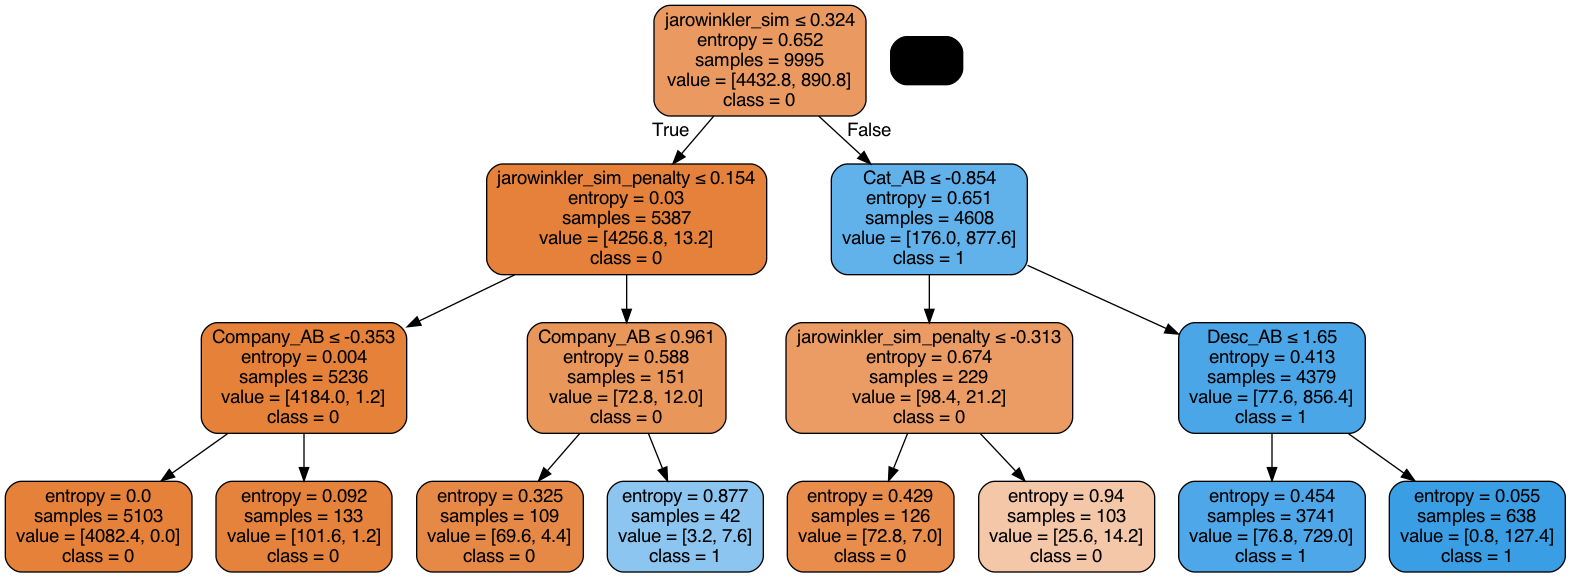

In [155]:
feature_cols = ['Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB']
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('DTree_optimized.png')
Image(graph.create_png())

In [157]:
# Check Missclassified Data - Random Forest 
df_3 = pd.DataFrame()
df_3['Actual'] = y_test
df_3['Label_DT'] = y_pred
df_3['Label_KNN'] = y_predict
df_3['Label_SGD'] = predicted_SGD
df_2 = pd.DataFrame(X_test,columns = ['Company_A','Company_B','CompanyA','CompanyB','Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB'])
df_2 = df_2.join(df_3)

In [158]:
df_2.to_csv("Output/Test_result_final.csv")

In [189]:
# df_2.to_csv("Output/Prediction_2nd_iter.csv")

## 2nd Approach

In [201]:
# Assign values to the X and y variables:
X = new_data.iloc[:, :10].values
y = new_data.iloc[:, 10].values 

In [202]:
y = y.astype(np.float)

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/3104899586.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=135)
X_train_new = [x[4:] for x in X_train]
X_test_new = [x[4:] for x in X_test]

In [204]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train_new)
X_train_new = imp.transform(X_train_new)
X_test_new = imp.transform(X_test_new) 

# Standardize features by removing mean and scaling to unit variance:
scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_new = scaler.transform(X_train_new)
X_test_new = scaler.transform(X_test_new) 

In [205]:
# Use the KNN classifier to fit data:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_new, y_train) 
# Predict y data with classifier: 
y_predict = classifier.predict(X_test_new)
# Print results: 
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict)) 
print(accuracy_score(y_test, y_predict))
cohen_kappa_score(y_test, y_predict)

[[678  23]
 [ 12 547]]
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       701
         1.0       0.96      0.98      0.97       559

    accuracy                           0.97      1260
   macro avg       0.97      0.97      0.97      1260
weighted avg       0.97      0.97      0.97      1260

0.9722222222222222


0.9438416870415648

In [206]:
# Random Forest Classifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
threshold = 0.8
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_train_new,y_train)
predicted_proba = trainedforest.predict_proba(X_test_new)
predictionforest = (predicted_proba[:,1] >= threshold).astype('int')

# print(confusion_matrix(y_test,predictionforest))
# print(classification_report(y_test,predictionforest))
# # Evaluate label (subsets) accuracy:
print(accuracy_score(y_test, predictionforest))

print("Cohen kappa",cohen_kappa_score(y_test, predictionforest))

0.9674603174603175
Cohen kappa 0.9338316665300435


In [207]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train_new,y_train)
predicted_proba = clf.predict_proba(X_test_new)
predictionLR = (predicted_proba[:,1] >= threshold).astype('int')

# print(confusion_matrix(y_test,predictionforest))
# print(classification_report(y_test,predictionforest))
# # Evaluate label (subsets) accuracy:
print(accuracy_score(y_test, predictionLR))


0.9238095238095239


In [208]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
sgd = make_pipeline(StandardScaler(),
SGDClassifier(max_iter=1000, tol=1e-3))
sgd.fit(X_train_new,y_train)

predicted_SGD = sgd.predict(X_test_new)
log_probab = sgd.decision_function(X_test_new)

# print(confusion_matrix(y_test,predictionforest))
# print(classification_report(y_test,predictionforest))
# # Evaluate label (subsets) accuracy:
print(accuracy_score(y_test, predicted_SGD))

0.9619047619047619


In [209]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train_new,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_new)
print(accuracy_score(y_test, y_pred))

0.9706349206349206


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


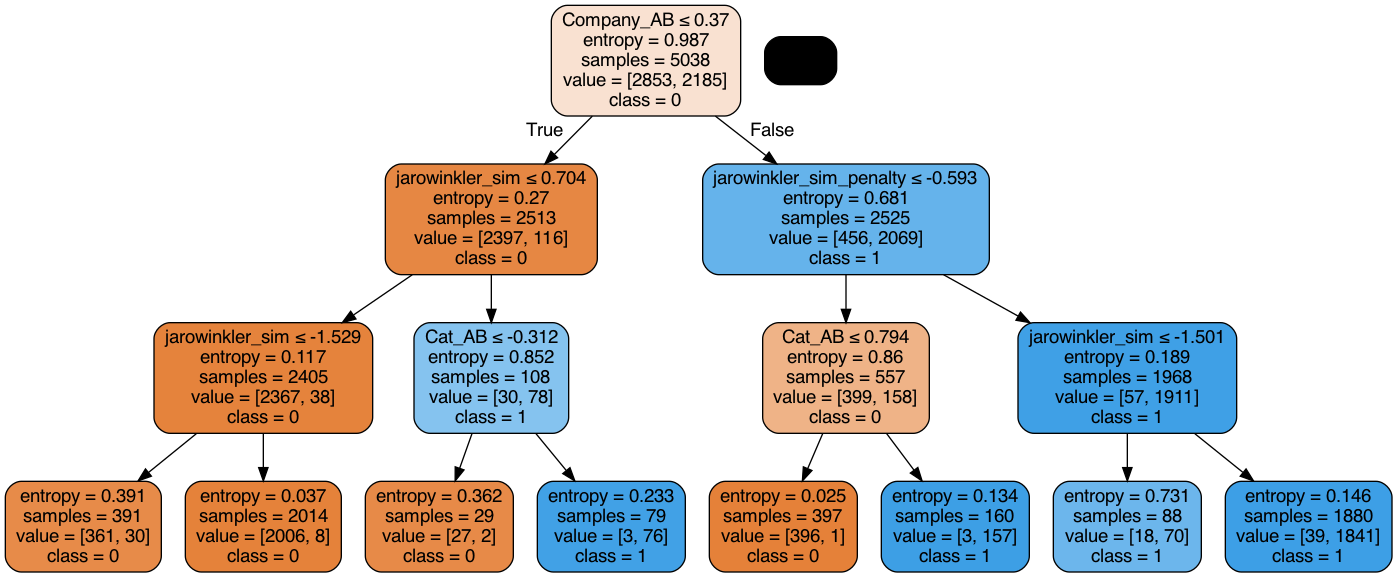

In [210]:
feature_cols = ['Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB','Sim_AB']
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('DTree_optimized.png')
Image(graph.create_png())

## Testing on Same Test dataset of 1st Iteration

In [214]:
# Assign values to the X and y variables:
X = df.iloc[:, :10].values
y = df.iloc[:, 10].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=135)
X_train_new = [x[4:] for x in X_train]
X_test_new = [x[4:] for x in X_test]

In [218]:
X_unseen = imp.transform(X_test_new)
X_unseen = scaler.transform(X_unseen)

In [219]:
# KNN
predictive_labels_KNN = classifier.predict_proba(X_unseen)
threshold = 0.8
predictionKNN = (predictive_labels_KNN[:,1] >= threshold).astype('int')

In [222]:
test_df = pd.DataFrame()
test_df['Label_KNN']  = predictionKNN

In [223]:
predicted_SGD = sgd.predict(X_unseen)
test_df['Label_SGD']  = predicted_SGD

In [224]:
predicted_DT = clf.predict(X_unseen)
test_df['Label_DT']  = predicted_DT

In [226]:
X_test

array([['PEPPERL & FUCHS INC', 'P&F', 'pepperl fuchs', ..., 0.52,
        0.9979911987655324, 0.4385819733142853],
       ['ENVIRONMENTAL ELEMENTS CO', 'FORRY INC',
        'environmental elements', ..., 0.42, 0.8947510273798946,
        0.06310588121414185],
       ['ALLEN BRADLEY', 'CARMANAH DES', 'allen bradley', ..., 0.61,
        0.2512348129102518, 0.20917551219463348],
       ...,
       ['SIEMENS APPLIED AUTOMATIO', 'SIEMENS ENERGY AND AUTOMA',
        'applied automatio', ..., 0.7, 0.9704033911923404,
        0.742530345916748],
       ['ALLEN BRADLEY', 'FSC', 'allen bradley', ..., 0.0,
        0.9843128785116342, 0.14555947482585907],
       ['M&CPRODUCT', 'M&CPRODUCTS', 'm&cproduct', ..., 0.98,
        0.8698809765627862, 0.9514281749725342]], dtype=object)

In [227]:
# Check Missclassified Data - Random Forest 
df_3 = pd.DataFrame()
df_3['Actual'] = y_test
df_3['Predicted'] = predicted_DT
df_2 = pd.DataFrame(X_test,columns = ['Company_A','Company_B','CompanyA','CompanyB','jarowinkler_sim','jarowinkler_sim_penalty','Company_AB','Desc_AB','Sim_AB','Cat_AB'])
df_2 = df_2.join(df_3)

In [228]:
df_2

Company_A                  Company_B  \
0          PEPPERL & FUCHS INC                        P&F   
1    ENVIRONMENTAL ELEMENTS CO                  FORRY INC   
2                ALLEN BRADLEY               CARMANAH DES   
3                    FLOWSERVE                   STERLING   
4    GOULDS PUMPS / ITT INDUST                    REXROTH   
..                         ...                        ...   
260              HARNISCHFEGER   MORRIS MATERIAL HANDLING   
261                METSO PAPER                METSO POWER   
262  SIEMENS APPLIED AUTOMATIO  SIEMENS ENERGY AND AUTOMA   
263              ALLEN BRADLEY                        FSC   
264                 M&CPRODUCT                M&CPRODUCTS   

                   CompanyA                  CompanyB jarowinkler_sim  \
0             pepperl fuchs                       p&f             0.0   
1    environmental elements                     forry             0.0   
2             allen bradley              carmanah des             0.0   
3                 flowserve                  sterling             0.0   
4                                             rexroth             0.0   
..                      ...                       ...             ...   
260           harnischfeger  morris material handling             0.0   
261             metso paper                     metso        0.726563   
262       applied automatio             energy automa             0.0   
263           allen bradley                       fsc             0.0   
264              m&cproduct               m&cproducts             0.0   

    jarowinkler_sim_penalty Company_AB Desc_AB    Sim_AB    Cat_AB  Actual  \
0                  0.586846       0.52    0.52  0.997991  0.438582     1.0   
1                  0.041292       0.42    0.42  0.894751  0.063106     0.0   
2                  0.235243       0.61    0.61  0.251235  0.209176     0.0   
3                  0.093504       0.48    0.48  0.850227  0.354551     0.0   
4                  0.166782        0.0     0.0  0.232534  0.321177     0.0   
..                      ...        ...     ...       ...       ...     ...   
260                0.545393       0.53    0.53  0.979067  0.217532     0.0   
261                 0.08961       0.89    0.89  0.956665  0.779925     0.0   
262                0.274019        0.7     0.7  0.970403   0.74253     1.0   
263                0.109719        0.0     0.0  0.984313  0.145559     0.0   
264                0.234701       0.98    0.98  0.869881  0.951428     1.0   

     Predicted  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
..         ...  
260        0.0  
261        1.0  
262        1.0  
263        0.0  
264        1.0  

[265 rows x 12 columns]

In [229]:
df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 1]

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/2033149000.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 1]


Company_A                  Company_B  \
14                        MISC US BEARING                         US   
15                  ERNST FLOW INDUSTRIES                 ERNST GAGE   
17                          CAN-AM CHAINS                   CAN-AMER   
21               METSO AUTOMATION USA INC                METSO PAPER   
52                         PAPE MACHINERY       PAPER MACHINERY CORP   
53               TOSHIBA AMERICA CONSUMER           TOSHIBA ELECTRIC   
58                       PARKER HYDRAULIC          PARKER PNEUMATICS   
59                            CATERPILLAR              CUTLER HAMMER   
79                      QUINCY COMPRESSOR     QUINCY SPECIALITES CO.   
83               METSO AUTOMATION USA INC              METSO/KAJAANI   
104                          PARKER FLUID            PARKER HANNIFIN   
118                    FEDERAL MOGUL CORP                 FEDERALSIG   
131                     QUINCY COMPRESSOR     QUINCY SPECIALITES CO.   
138                         KB ELECTRONIC                       KBIC   
146                   VICTOR EQUIPMENT CO             VICTOR WELDING   
164                   TSUBAKI CONVEYOR CO       TSUBAKIMOTO CHAIN CO   
181             PNEUMATIC & HYDRAULICS CO          PNEUMATIC COMPANY   
182                    MILLER FLUID POWER               MILLER SALES   
202                         REX CHAINBELT            REX ENGINEERING   
207  LINDEN FABRICATING & ENGINEERING LTD       LINDEN MANUFACTURING   
210                  SIGNET SCIENTIFIC CO  SIGNODE PACKAGING SYSTEMS   
217                  MILLER HONEY COMPANY    MILLER SAFETY EQUIPMENT   
220                BROWN PAPER CONVERTING   PAPER CONVERTING MACHINE   
221                                   SUN        SUN HYDRAULICS CORP   
223              ENVIRONMENTAL CONSULTING  ENVIRONMENTAL ELEMENTS CO   
228             TOSHIBA INTERNATIONAL COR               TOSHIBAMERIC   
229                 AES ENGINEERED SYSTEM       ALBANY ENGINEERED SY   
235                               MARQUIP     MARTIN SPROCKET & GEAR   
240                   LITTLE GIANT LADDER          LITTLE GIANT PUMP   
243                               MARQUIP                 MARQUIPWAR   
256               ADAMS MAGNETIC PRODUCTS           MASTER MAGNETICS   
257               LINCOLN LUBE INDUSTRIAL           LINCOLN ST LOUIS   
261                           METSO PAPER                METSO POWER   

                           CompanyA                CompanyB jarowinkler_sim  \
14                               us                      us             1.0   
15                       ernst flow              ernst gage        0.480974   
17                    can-am chains                can-amer        0.393119   
21                            metso             metso paper        0.726563   
52                             pape                   paper             0.0   
53         toshiba america consumer                 toshiba        0.518523   
58                 parker hydraulic       parker pneumatics        0.366785   
59                      caterpillar           cutler hammer             0.0   
79                quincy compressor     quincy specialites         0.489538   
83                            metso           metso kajaani        0.627187   
104                          parker         parker hannifin        0.676678   
118                   federal mogul              federalsig             0.0   
131               quincy compressor     quincy specialites         0.489538   
138                              kb                    kbic             0.0   
146                          victor          victor welding         0.68006   
164                tsubaki conveyor       tsubakimoto chain             0.0   
181                       pneumatic               pneumatic             1.0   
182                          miller                  miller             1.0   
202                   rex chainbelt         rex engineering        0.487742   
207

In [231]:
len(df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 0])

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/2204474174.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 0])


29

In [232]:
len(df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 1])

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/4128229866.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 1])


33

In [234]:
df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 0]


/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/3950092250.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 0]


Company_A                  Company_B  \
0          PEPPERL & FUCHS INC                        P&F   
8                       CARTER              CARTER DAY CO   
18                       CROWN                  CROWN ENG   
30                  MARQUIPWAR               WARD MACHINE   
41                     HOFFMAN                     MCLEAN   
46                    APPLETON                       RACO   
50                          CM                        C&M   
69   LIQUID SOLIDS CONTROL INC                        LSC   
73                     GENERAL    GENERAL SAW CORPORATION   
81                      SIEMEN  SIEMENS ENERGY AND AUTOMA   
87                 EXXON MOBIL                      MOBIL   
92                     WESTERN              WESTERN DIAZO   
105             EATON AIR FLEX                     FAWICK   
114                   WURZBURG          WURZBURG BROTHERS   
115         SCHNEIDER ELECTRIC           SQUARE D COMPANY   
117              BOSCH REXROTH                    REXROTH   
129                     YAMAHA            YAMAHA ROBOTICS   
141                EATONVICKER                    VICKERS   
143                        MAC             MAC VALVES INC   
153                     AMETEK                        NCC   
156                    CELLECO                       GL&V   
160            EWELLIX USA LLC                SKF USA INC   
163                        RBC  ROLLER BEARINGS OF AMERIC   
177                MTS SYSTEMS                      TEMPO   
187                        ASC                       ASCO   
199                     BUCHER   BUCHER HYDRAULICS CANADA   
213                 BECK HAROL     HAROLD BECK & SONS INC   
234                MACVALVEINC             MAC VALVES INC   
251                     SAMUEL   SAMUEL PACKAGING SYSTEMS   

                  CompanyA           CompanyB jarowinkler_sim  \
0            pepperl fuchs                p&f             0.0   
8                   carter         carter day        0.707107   
18                   crown          crown eng        0.768413   
30              marquipwar               ward             0.0   
41                 hoffman             mclean             0.0   
46                appleton               raco             0.0   
50                      cm                c&m             0.0   
69   liquid solids control                lsc             0.0   
73                 general        general saw        0.508523   
81                  siemen      energy automa             0.0   
87             exxon mobil              mobil        0.707107   
92                 western      western diazo         0.68718   
105         eaton air flex             fawick             0.0   
114               wurzburg  wurzburg brothers        0.707107   
115              schneider             square             0.0   
117          bosch rexroth            rexroth        0.687383   
129                 yamaha    yamaha robotics        0.707107   
141            eatonvicker            vickers             0.0   
143                    mac         mac valves        0.725163   
153                 ametek                ncc             0.0   
156                celleco               gl&v             0.0   
160                ewellix                skf             0.0   
163                    rbc      roller americ             0.0   
177                    mts              tempo             0.0   
187                    asc               asco             0.0   
199                 bucher      bucher canada         0.75156   
213             beck harol   harold beck sons        0.372979   
234            macvalveinc         mac valves             0.0   
251                 samuel   samuel packaging        0.802771   

    jarowinkler_sim_penalty Company_AB   Desc_AB    Sim_AB    Cat_AB  Actual  \
0                  0.586846       0.52      0.52  0.997991  0.438582     1.0   
8                  0.138939       0.92      0.92  0.045835  0.781813     1.0   